# Import Libraries and Mount Google Drive

In [ ]:
from google.colab import drive
import numpy as np
import cv2
import imageio
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage

drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Load High-Resolution Images

In [ ]:
high_path = '/content/gdrive/MyDrive/data/our485/high'
high_files = sorted(glob.glob(high_path + "/*.png"))

high_images = []
for file in high_files:
    image = imageio.imread(file)
    high_images.append(image)
high_images = np.array(high_images)


<ipython-input-16-790ddae6d9da>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


# Load Low-Resolution Images

In [ ]:
low_path = '/content/gdrive/MyDrive/data/our485/low'
low_files = sorted(glob.glob(low_path + "/*.png"))

low_images = []
for file in low_files:
    image = imageio.imread(file)
    low_images.append(image)
low_images = np.array(low_images)


<ipython-input-17-facddf56016f>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


# Split Data into Training and Testing Sets


---


In [ ]:
num_test_samples = int(0.1 * len(high_images))

test_indices = np.random.choice(len(high_images), num_test_samples, replace=False)

high_test = high_images[test_indices]
low_test = low_images[test_indices]

high_train = np.delete(high_images, test_indices, axis=0)
low_train = np.delete(low_images, test_indices, axis=0)


# Remove Unwanted Files

In [ ]:
!rm -rf '/content/gdrive/MyDrive/data/our485/low/.DS_Store'
!rm -rf '/content/gdrive/MyDrive/data/our485/high.DS_Store'

# Display Sample Images

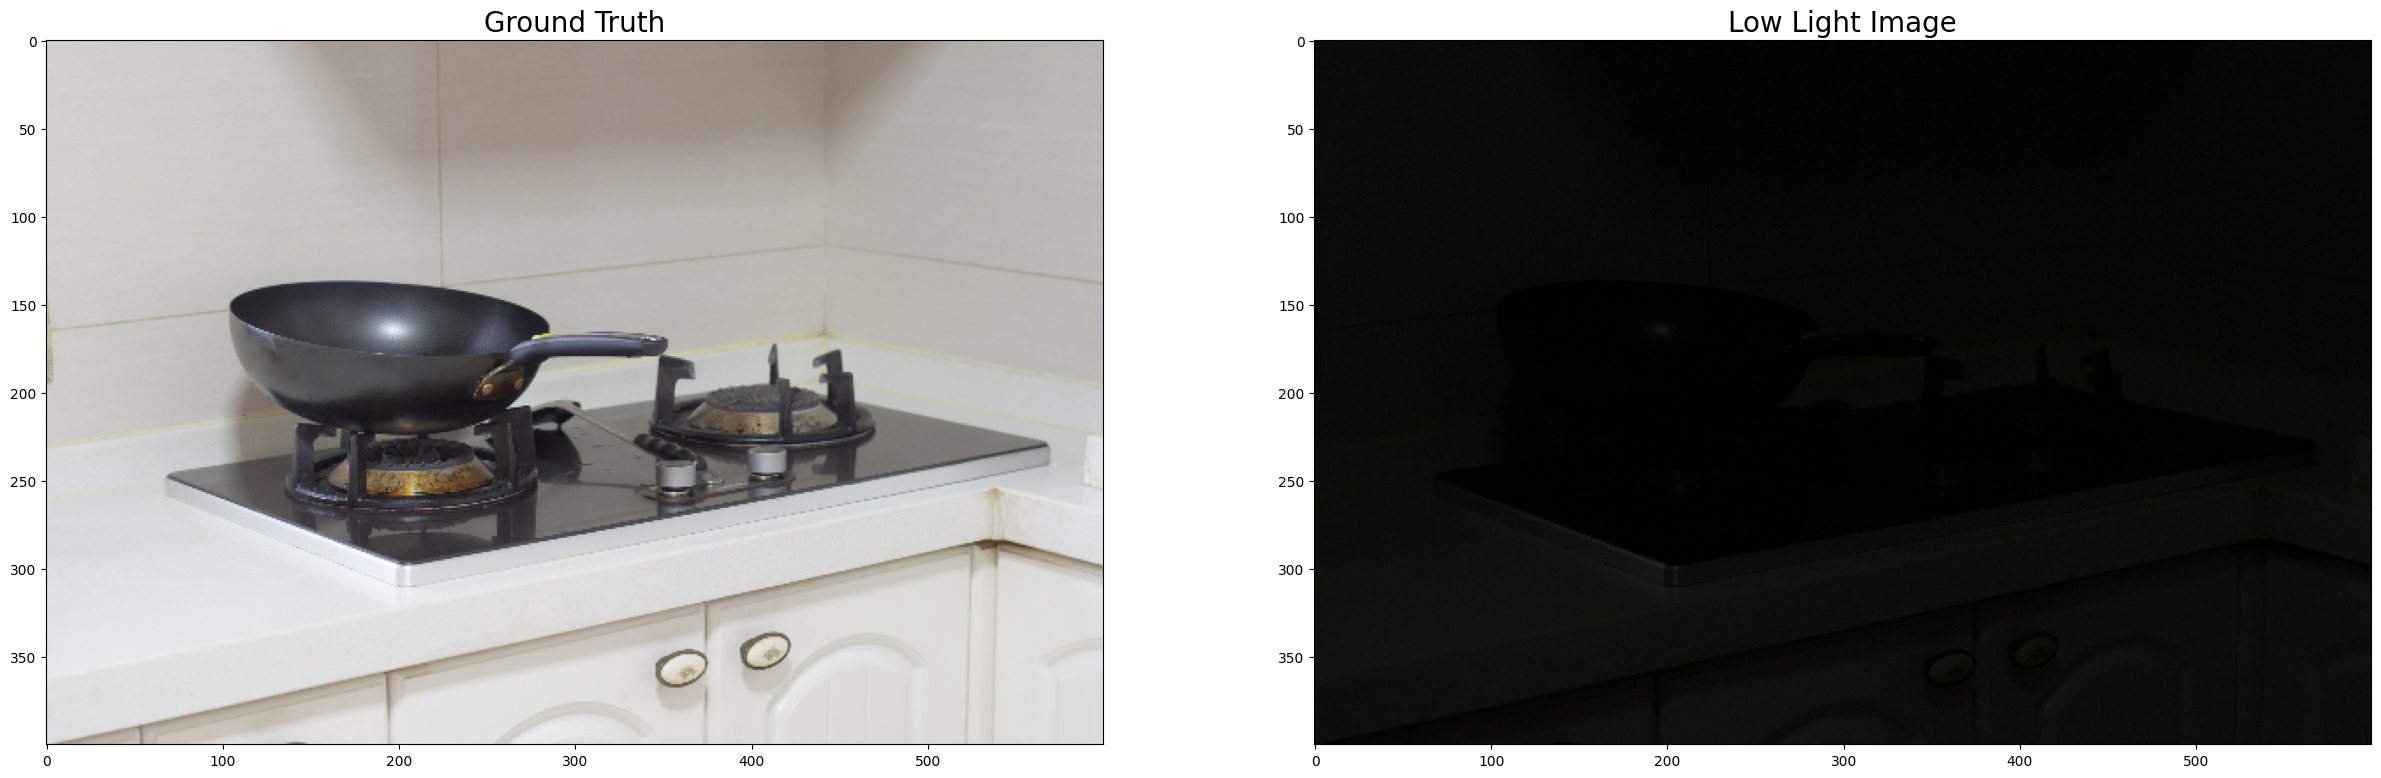

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.title("Ground Truth",fontsize=20)
plt.imshow(high[479])

plt.subplot(1,2,2)
plt.title("Low Light Image",fontsize=20)
plt.imshow(low[479])

# Define PSNR Metric

In [ ]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [ ]:
activation = 'relu'
Padding = 'same'
strides=(1,1)
kernel = (3,3)
inputs = keras.Input(shape=(None, None, 3), name='img')

# Create the Denoising Model

In [ ]:
# Creating model

layer1 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(inputs)

layer2 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer1)

layer3 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer2)

layer4 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer3)

layer5 = layers.add([layer3, layer4]) # Combination of 2 layers

layer6 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer5)

layer7 = layers.add([layer2, layer6]) # combination of 2 layers

layer8 = layers.Conv2D(32, kernel, activation=activation, padding=Padding)(layer7)

final = layers.add([layer1, layer8])

# For output we will use sigmoid activation for values between [0,1]
outLayer = layers.Conv2D(1, kernel, activation='sigmoid', padding=Padding)(final)

denoisingModel = keras.Model(inputs, outLayer)

# Compile and Summarize the Model

In [ ]:
denoisingModel.compile(optimizer="adam", loss='mean_squared_error', metrics=[psnr_metric])
denoisingModel.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, None, None, 32)       896       ['img[0][0]']                 
                                                                                                  
 conv2d_8 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_7[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_8[0][0]']            
                                                                                            

# Generate Inputs Function

In [ ]:
def generate_inputs(X, y):
    for i in range(len(X)):
        X_input = X[i].reshape(1, 400, 600, 3)
        y_temp = y[i] / 255
        if y_temp.shape[-1] == 1:
            y_temp = np.repeat(y_temp, 3, axis=-1)  # Converting grayscale to RGB
        y_input = y_temp.reshape(1, 400, 600, 3)
        yield (X_input, y_input[:, :, :, 0:1])  # Ensuring single channel for y_input


### Training the model

---



In [ ]:
denoisingModel.fit(generate_inputs(low_train, high_train), epochs=22, verbose=1, steps_per_epoch=22)



Epoch 1/22
22/22 [==============================] - 140s 6s/step - loss: 0.1243 - psnr_metric: 10.7981
Epoch 2/22
22/22 [==============================] - 115s 5s/step - loss: 0.0656 - psnr_metric: 12.2613
Epoch 3/22
22/22 [==============================] - 104s 5s/step - loss: 0.0504 - psnr_metric: 13.6423
Epoch 4/22
22/22 [==============================] - 94s 4s/step - loss: 0.0758 - psnr_metric: 12.1117
Epoch 5/22
22/22 [==============================] - 95s 4s/step - loss: 0.0714 - psnr_metric: 12.6129
Epoch 6/22
22/22 [==============================] - 92s 4s/step - loss: 0.0599 - psnr_metric: 13.3568
Epoch 7/22
22/22 [==============================] - 93s 4s/step - loss: 0.1002 - psnr_metric: 11.9525
Epoch 8/22
22/22 [==============================] - 95s 4s/step - loss: 0.0442 - psnr_metric: 13.8016
Epoch 9/22
22/22 [==============================] - 94s 4s/step - loss: 0.0287 - psnr_metric: 15.7085
Epoch 10/22
22/22 [==============================] - 100s 5s/step - loss: 0.028

22/22 [==============================] - 83s 4s/step - loss: 0.0253 - psnr_metric: 17.3732


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load the Model

---



In [ ]:
denoisingModel.save('/content/gdrive/MyDrive/FINAL_MODEL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/gdrive/MyDrive/FINAL_MODEL.h5'
model = load_model(model_path, custom_objects={'psnr_metric': psnr_metric})


## Testing


---

In [ ]:
X= low_test

# Enhance Function


In [ ]:
def enhance(img, index, flag, psnr_list=None):
    if psnr_list is None:
        psnr_list = []

    if index == 0:
        return img, psnr_list

    elif flag == 1:
        h, w, c = img.shape
        prediction = model.predict(img.reshape(1, h, w, 3))
        temp = img / 255
        enhanced_image = temp + ((prediction[0] * temp) * (1 - temp))
        psnr_value = psnr_metric(tf.convert_to_tensor(img, dtype=tf.float32), tf.convert_to_tensor(enhanced_image * 255, dtype=tf.float32)).numpy()
        psnr_list.append(psnr_value)
        return enhance(enhanced_image, index - 1, 0, psnr_list)

    else:
        h, w, c = img.shape
        prediction = model.predict(img.reshape(1, h, w, 3))
        enhanced_image = img + ((prediction[0] * img) * (1 - img))
        psnr_value = psnr_metric(tf.convert_to_tensor(img, dtype=tf.float32), tf.convert_to_tensor(enhanced_image, dtype=tf.float32)).numpy()
        psnr_list.append(psnr_value)
        return enhance(enhanced_image, index - 1, flag, psnr_list)


###**Examples**

---



1/1 [==============================] - 1s 787ms/step


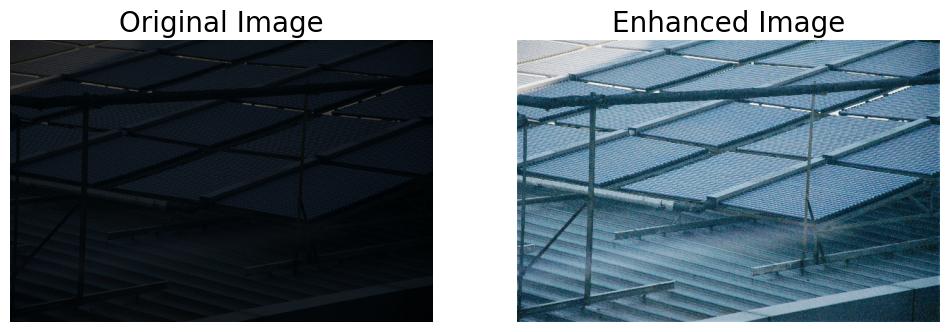

PSNR Value: 22.295143


In [ ]:
test_image = low_test[0]
iterations = 8

enhanced_image, psnr_list = enhance(test_image, iterations, 1)
psnr_array = np.array(psnr_list)
psnr_values = [psnr_array[iterations - 1]]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image", fontsize=20)
plt.imshow(test_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced Image", fontsize=20)
plt.imshow(enhanced_image)
plt.axis('off')

plt.show()

print("PSNR Value:", psnr_array[iterations - 1])


1/1 [==============================] - 1s 547ms/step


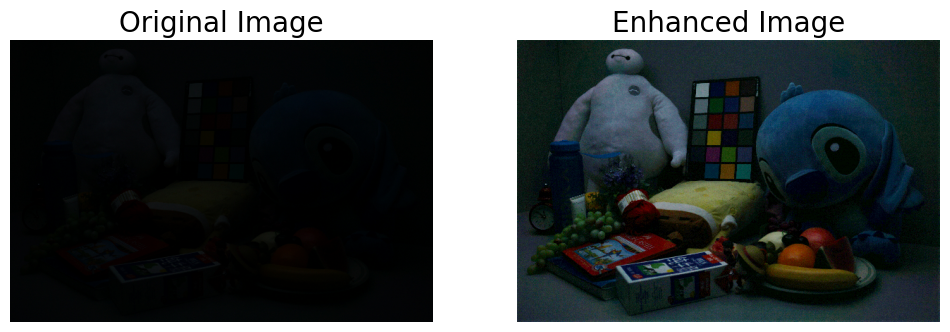

PSNR Value: 28.435375


In [ ]:
Image = X[18]
Index = 8
enhanced_image, psnr_list = enhance(Image, Index, 1)
psnr_array = np.array(psnr_list)
psnr_values=[]
psnr_values.append(psnr_array[Index-1])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image", fontsize=20)
plt.imshow(Image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced Image", fontsize=20)
plt.imshow(enhanced_image)
plt.axis('off')

plt.show()

print("PSNR Value:", psnr_array[Index-1])

1/1 [==============================] - 1s 808ms/step


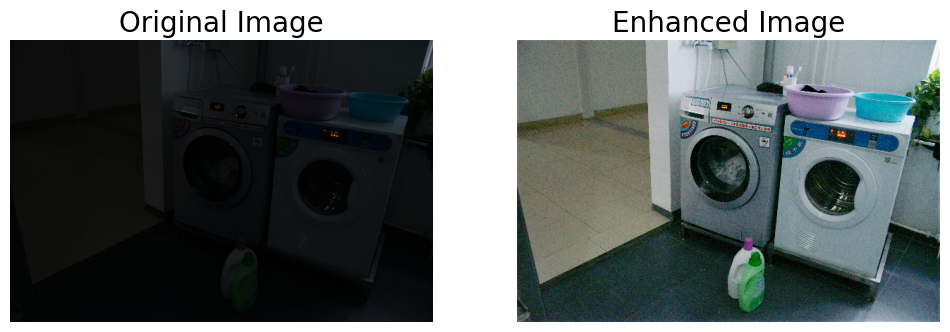

PSNR Value: 22.597988


In [ ]:
Image = X[9]
Index = 8
enhanced_image, psnr_list = enhance(Image, Index, 1)
psnr_array = np.array(psnr_list)
psnr_values=[]
psnr_values.append(psnr_array[Index-1])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image", fontsize=20)
plt.imshow(Image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced Image", fontsize=20)
plt.imshow(enhanced_image)
plt.axis('off')

plt.show()

print("PSNR Value:", psnr_array[Index-1])

In [ ]:
psnr_values = []

for i in range(len(low_test)):
    Image = X[i]
    Index = 8
    enhanced_image, psnr_list = enhance(Image, Index, 1)
    psnr_array = np.array(psnr_list)
    psnr_values.append(psnr_array[Index-1])

average_psnr = np.mean(psnr_values)
print("Average PSNR Value:", average_psnr)

1/1 [==============================] - 1s 524ms/step
Average PSNR Value: 23.802893


**Final average psnr on testing data = 23.802893**